In [1]:
import numpy as np
import control as ct
from planar_quad import PlanarQuad
import matplotlib.pyplot as plt

In [2]:
mass = 0.6
length = 0.2
inertia = 0.15
gravity = 9.81
dt = 0.01
quad = PlanarQuad(dt, mass, length, inertia, gravity)
A, B = quad.linear_dyn(np.zeros((6, )), np.array([quad.m * quad.g / 2, quad.m * quad.g / 2]))
C = np.array([[1, 0, 0, 0, 0, 0],[0, 0, 1, 0, 0, 0]])
# Start with a diagonal weighting
Q_ctrl = np.array([[1e0, 0., 0., 0., 0., 0.],
                           [0., 1e0, 0., 0., 0., 0.],
                           [0., 0., 1e0, 0., 0., 0.],
                           [0., 0., 0., 1e0, 0., 0.],
                           [0., 0., 0., 0., 1e0, 0.],
                           [0., 0., 0., 0., 0., 1e0]])

R_ctrl = np.array([[1e1, 0.],
                           [0., 1e1]])

K, _, _ = ct.dlqr(A, B, Q_ctrl, R_ctrl)  

Q_est = np.eye(6)
R_est = np.eye(2)

L, _, _ = ct.dlqe(A, np.eye(6), C, Q_est, R_est)  

A_delta = np.block([[A-B@K, B@K, np.zeros((6,6))], 
                   [np.zeros((6,6)), A-L@C@A, np.zeros((6,6))],
                   [np.zeros((6,6)), np.zeros((6,6)), (np.eye(6) - L@C)@A - B@K]])

B_delta = np.block([[np.zeros((6,2))],
                    [-L@np.eye(2)],
                    [L@np.eye(2)]
                    ])
W_delta = np.block([[np.eye(6), np.zeros((6,2))],
                    [(np.eye(6) - L@C), -L],
                    [np.zeros((6,6)),np.zeros((6,2))]])

C_tilde = np.array([[1, 0, 0, 0, 0, 0],[0, 0, 1, 0, 0, 0]])
C_delta = np.block([[C_tilde,np.zeros((2,6)),np.zeros((2,6))],
                    [np.zeros((2,6)),np.zeros((2,6)),C_tilde]])
M = np.block([np.zeros((2,6)),np.zeros((2,6)),-C])
Q_delta_est = np.eye(18)
R_delta_est = np.eye(4)
Lo, _, _ = ct.dlqe(A_delta, np.eye(18), C_delta, Q_delta_est, R_delta_est) 

In [3]:
import cvxpy as cp
from scipy.linalg import sqrtm

def solve_lmi(A, B, eta, r_max=1, n_states=6, verbose=False):
    ## M Kothare LMI Implementation for constant reference tracking
    n = n_states*3 # Augmented state dim
    m = B.shape[1] # Attack vector dim
    Q = cp.Variable((n,n), PSD=True)
    Y = cp.Variable((m,n))

    gamma = cp.Variable()
    
    T_1 = np.zeros((6,6))
    T_1[0,0] = 1
    T_1[2,2] = 1
    T_1[4,4] = 1
    T = np.block([T_1, np.zeros((6,6)),np.zeros((6,6))])

    M_3 = np.zeros((6,6))
    M_3[0,0] = 1
    M_3[2,2] = 1
    M_3[4,4] = 0
    M = np.block([np.zeros((6,6)),np.zeros((6,6)), M_3])
    #M = np.block([np.zeros((6,6)),np.zeros((6,6)), np.eye(6)])
    Q_curly = 1e2*(T.T@np.eye(n_states)@T)
    #Q_curly = 1e3*np.eye(n)
    block_eq1 = cp.bmat([
        [Q, Q@A.T+Y.T@B.T, Q@sqrtm(Q_curly)],
        [A@Q+B@Y,  Q,  np.zeros((n,n))],
        [sqrtm(Q_curly)@Q,np.zeros((n,n)), gamma*np.eye(n)]])
    
    block_eq2 = cp.bmat([
        [np.eye(1), eta.T],
        [eta,Q]])
    
    block_eq3 = cp.bmat([
        [Q, (A@Q+B@Y).T@M.T],
        [M@(A@Q+B@Y), r_max**2*np.eye(n_states)]])
    
    const = [block_eq1 >> 0, block_eq2>>0, block_eq3>>0]
    prob = cp.Problem(cp.Minimize(gamma), constraints = const)
    try:
        prob.solve(solver = cp.MOSEK, verbose=verbose)
        cost = gamma.value
    except Exception as e:
        print(e)
        cost = -1       
    return {
        'cost': cost,
        'F': np.round(np.array(Y.value @ np.linalg.inv(Q.value)), 3),
        'Q': np.round(np.array(Q.value), 3),
        'gamma': gamma.value
    }

res = solve_lmi(A_delta, B_delta, np.zeros((18,1)),  n_states=6)

In [355]:
N =250
t = np.zeros([N+1,])
x0 = np.array([0.0, 0., 0., 0., 0, 0.])

eta = np.empty([18, N+1])
eta_est = np.empty([18, N+1])
a = np.empty([2, N+1])


eta[:,0] = np.block([x0, np.zeros(6), np.zeros(6)])
eta_est[:,0] = np.block([x0, np.zeros(6), np.zeros(6)])

delta = np.empty([6, N+1])
delta[:,0] = np.zeros(6)

a_star = np.array([2.3,0.0])
eta_star = np.zeros((18,))
eta_star[0] = a_star[0]
eta_star[2] = a_star[1]
eta_star[6] = a_star[0]
eta_star[8] = a_star[1]

gamma = np.zeros([N,])

a[:,0] = - a_star
r_max = 5.0


x0 = np.array([0.0, 0., 0., 0., 0, 0.])
x0_est = np.array([0.0, 0., 0., 0., 0, 0.])
x0_est_0 = np.array([0.0, 0., 0., 0., 0, 0.])

t = np.zeros([N+1,])
x = np.empty([6, N+1])
x_est = np.empty([6, N+1])
x[:,0] = x0
x_est[:,0] = x0_est
x_est_0 = np.empty([6, N+1])
x_est_0[:,0] = x0_est_0

A, B = quad.linear_dyn(np.zeros((6, )), np.array([quad.m * quad.g / 2, quad.m * quad.g / 2]))

for i in range(N):
    w = 0.001*np.random.randn(6)
    v = 0.1*np.random.randn(2)
    w_tilde = np.block([w,v])
    print(i, a[:,i], res['gamma'])

    eta[:,i+1] = eta_star + A_delta@(eta[:,i] - eta_star) + B_delta@(a[:,i])+ W_delta@w_tilde    
    t[i+1] = t[i] + 0.01
    
    err = eta[:,i+1] - eta_star
    res = solve_lmi(A_delta, B_delta, np.reshape(err,(18,1)), r_max, n_states=6, verbose = False)
    F_obs = res['F']
    gamma[i] = res['gamma']
    a[:,i+1] = F_obs@(eta[:,i+1] - eta_star) 

    x[:,i+1] = A@x[:,i] - B@K@x_est[:,i] + w 
    y = a[:,i] + v + C@(x[:,i+1]) - a_star
    y_0 = C@x[:,i+1] + v
    
    x_est[:,i+1] = (A - B@K)@x_est[:,i] + L@(y - C@((A - B@K)@x_est[:,i]))
    x_est_0[:,i+1] = A@x_est_0[:,i] - B@K@(x_est[:,i]) + L@(y_0 - C@(A@x_est_0[:,i] - B@K@(x_est[:,i])))
    delta[:,i+1] = ((np.eye(6) - L@C)@A - B@K)@delta[:,i] + L@(a[:,i] - a_star) + L@C@A@eta_star[:6]
    print(np.linalg.norm(y - C@((A - B@K)@x_est[:,i])))
    print(np.linalg.norm(y_0 - C@(A@x_est_0[:,i] - B@K@(x_est[:,i]))))

state = x
state_est = x_est
state_est_0 = x_est_0

0 [-2.3 -0. ] 1.4786770441729535
4.585703338738942
0.18552525086355634
1 [-4.66610140e-01  2.11384411e-04] 35090.008608074284
0.6163421929303409
0.26401285290244053
2 [-0.63137805  0.00762217] 34521.26443664989
0.20120891327902743
0.06813141942139454
3 [-0.49623711  0.01100179] 33992.66808601876
0.20168590875094222
0.13226874188841098
4 [-0.39373342  0.00173573] 33436.66435515195
0.3356868461895866
0.014828258765686388
5 [-0.25732864 -0.02204365] 32800.15610810052
0.34105537299292404
0.07474535958727999
6 [-0.14910408 -0.02203165] 32237.829117428853
0.44627719361121104
0.12266392061713849
7 [-0.03770869 -0.00838216] 31628.591817318364
0.4971407494990219
0.19966875228770478
8 [ 0.07480224 -0.00725401] 31086.720090744275
0.23453125572824823
0.15929030518572906
9 [ 0.18156358 -0.01330996] 30518.719163539903
0.33826025822667394
0.10942963884412467
10 [0.2808705  0.00685003] 29938.96057295757
0.3760092124385095
0.0945620458430183
11 [0.38224121 0.00272875] 29351.509750584883
0.0877148181630

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAKmZtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTI3
IGxvb2thaGVhZF90aHJlYWRzPTQgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DDFliIQAEP/+94G/MstfIrrJcfnnfSyszzzkPHJdia640AAAAwAAAwAAAwAGIxI3/ofxeM38AAAD
AAC3ABhQDCAKqAvuR9LikjcACcktaTz5B5hbdkZdOhsfH60fup5FnPmPe/m0diHXAMXGSdEBtrWn
5SMT7F2CiyR5TE8Xl2V0WEVWcLrk/90fIQUOKSHZUKh3heETa4e0ZbBN4uNKKv0ms/aPCVrW5zZL
d3f+Cl7752QjxvzOqcT/2xKl1NL8IVQsQHKQF/EoheFgdPTa1ZFuihXIkEg+2xTPCQk5Ia2KbnZU
d/rnjf8443APrvyGEnA8KUoDPZ67bVK+WomABUo2Gv4xPGrPSAAAAwM74g56NczGd1hy2LUvUlMq
5JmkgYKGmK7kaGX0a1KdwJ3kSkifPm0yOQIaYPkDeVjSEEVs01AGJDNAPoV0sPcLArIokPD+2Kpd
jFJglc7xTZpmJ67XLb0h0zFHy2aBttsoqi8k6hbKiOiiSz2785cvAyGRWwfXQ9jGyGDjQPDv9Q/g
yB5zhJ8Mn8e9vPsth8ChSCYsuAGiQeSlf8gtkIo9NxUysBgZucu4+1afWIG61V8sU20Hl0ObGk1r
KRvFNC7TqEjE/ylm9d8AugemqEADbFEI7J4AK8HdcSECnjledqyArCajZ/ti2Ran1O8nQS2NMmSc
0PrNWmN3hP2egBXVmtrmYYsSNaJOrBUS4GZfVsBmIomhhUK0SWJ0AKGafgVF6rGejGIjCXrrGxE8
A2Xjb5Vo85dOwPEIO2vUf9l24EAC/AAAAwAAAwAAAwAAAwAAAwO65tFlxGjZ6XTutjsOhZ2Npefy
exZaeK3OF6sljlU0s/Om1MVXMbAs9qAcoGLZLPXzPwwrPUX5+OOEO0W5tNMonyFkWWPymJBhWcxu
aotsDFONCaTK82y/zD0f6T0g8jP//84gA1iSrXtf/o68K+D6EAiBJ2FuzQpcu0oWGz+mxQbi5vLw
QIMPH5Eo7m44JtRmctjkBFU0eYUwGT8DZjfRI5e/MhPNa8YzaL7kjY0KKxvtzELZPr9WphjQdKLY
w39SuqPEdi70vIDmTOBJucljdgt0PQB4m0Av6dY/8VT6LbkyntEbwfENtMfFzJ+2+YfFOgMUFVne
QHw2KMw91/qD0b/jO4AAAAMAAAMAAAMAAAMAAAMCgohYFXiBsmscPe/yrSkei4UG7GAejlBe3JQr
BGHL+nIVr/xCHUyxhU4yV9LywGdg1XVRjRxWkJjAStdQeFz9jst50/Swa+qrRegE2fCdyTcaex/B
U8jFUO9v1Zcu+chDMUANmGr1ZqslkEZXnSqAxJSPc5xby9nVmMsv0WCEzeTCkODySRQqZX5qV/Yy
Rw5t7+ZWHbqPMcBXksz90mnWtFOUPVQSPw2kjb6bJLRiIA0f+Oj0Dfm+wJuyiHFq1EZJdYZnw/7S
iO63Gqha0u8bjrtf8/axPyPfJxAEu8unS4drNOrXwFWqwYUXH3ie/eQ/AL7fu1SpYhsZK6zy6OQq
tc/n3NOlAAX0ne57KXKo8vVtGk5RgIXldJdoRmgqvZQ2CnwxTdduzguzhHTdSSpefgchlPb08I5p
KJc+B/FhRxXrJG90Ff9i2UPIiITlx8GeUKcJw5JScXQ8Mo0p99y+W7wPwhUo0nqouHtwaW3wxHKL
z/NPR53C8KvQvVtFRgZ+F+GvrA9bedJxYyaX1Y09fz+0Us2AmUkK+ADQKsGSHgrRG/L1NjX0RnUR
aBjDHyKzGcwiaYo2U0IHXWxJ8GhJR0rFEDiixkm5d5l3RQztUlqPHj992JSKlaAcNi5pBou1Odi2
2FoJuK9cALBK371P4Yexwq6mpt60iorL5fHL34PvQ7hA2wLcR1tMZhmlP65wOmgLR6fcj7e9A/Lq
5t7bIugYIslZQv/Djy6JWFztUrXFYqbIsHrNYOuQU076d7z3vSX9YOEe9vY8aX69Kf38Dl59Y4vk
YTMPXX7Z/+MvDxFPPlB9rXO/6kicMDRCDW90rtGP9qhPKdaqkcB49A8+4COAf38Zcts7YBHKBfOz
tdMZR+Vhkq16yL5gGylIKZg+8vytFI+0hDMEWO+OXeXCUSsfLAMCWP4PP3ZZHELrBqrKdIQa5/1b
scY1CLASeoPSWXh9bzTQtu+PKuTP8716xXeKPWaj2Sam5Lu8m2aKtDbrvh1+v3x4wKAKR00L26Ai
j/zDWGgNqCEjV+/C0z8hIUgC4AAAAwAAAwAAAwAAEkaQQj7V1csCFaC/35A72IwOxiPNCkPRTEoo
JPbfC7D+B6u3lgsERGybIbFddeFd6AEAAg9BiMyPnHDyloMT+bDpG7KxOeWR64iJLVdgCzBv/Psp
VI0uppu8hUDQsnHzs5aAmA7Pbs0DniuWWclMd3BohgrZLZiVJ2IJKCydHwdczkA1Wz3D94APHj6m
XTsUk4w/vCTIfmzizkNHSEqiY9Fxt5TbSopArVw2xou9YQbq+W278vNFo9zi2LH+wPIIk0qGbHn3
Rr2wrCiM66wVphhXyIOI+rP7oCdrE734/m4luh6Z2kD3AldaNXpgJRahtWtQJnziK/Av7DsrKBB1
Wo70Bbn4GhVJruyuiBKuxzSZvXa7eh65P6r/Gxljfw3uCw3p/0FrtiCEWORnUA97BEessArX91Fz
YiwfMYZLM3Hlq15JFXNgAKcMIeZoDhi2/kP7HocVnjU+2ilyM0PBHJ6UkTgXqD8Guecg3yaM1KQA
XUAABGwDLoLUIcI3AG3rl4ElWqDAH4Eb26HCwD3eSAsx/xfgrzjaYKmbJobdHRqvioRKldy2PAyU
mefKXErJOThqtNshKXMipz4aWlTLpf/qErBkoYcJAfEurcrJqcFXEcj0YdXu6ZpSPIyhi0ynS0ZT
SabUftN7FrjyO88mNS2/z

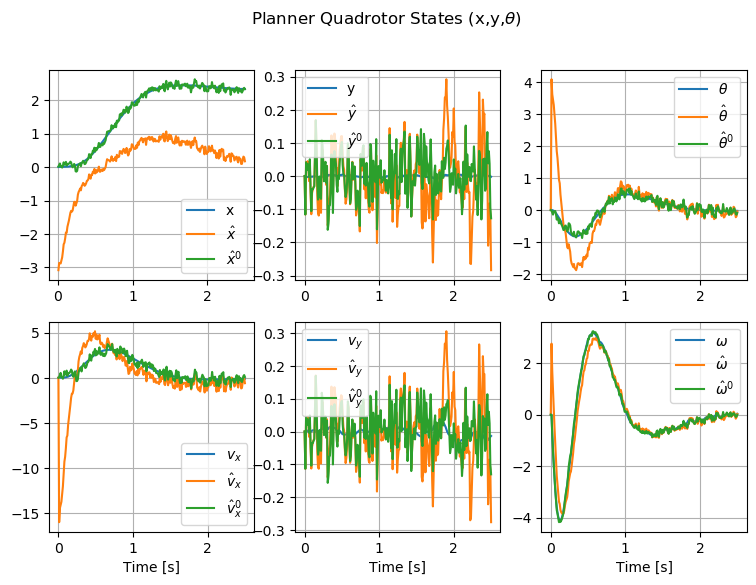

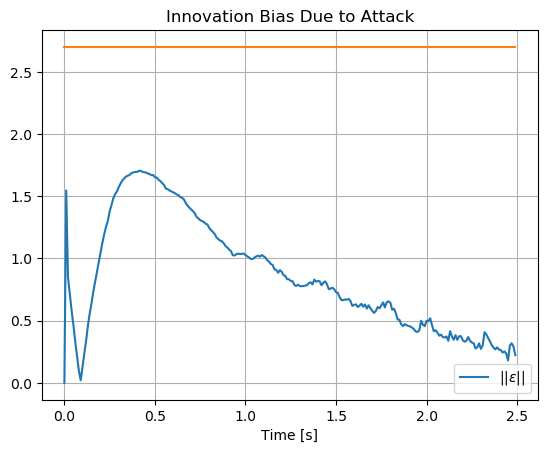

In [356]:
plt.figure(figsize=[9,6])
plt.suptitle('Planner Quadrotor States (x,y,$\\theta$)')
plt.subplot(2,3,1)
plt.plot(t[1:], state[0,1:])
plt.plot(t[1:], state_est[0,1:])
plt.plot(t[1:], state_est_0[0,1:])
plt.grid()
plt.legend(['x','$\hat{x}$','$\hat{x}^0$'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.plot(t, state_est[2,:])
plt.plot(t, state_est_0[2,:])
plt.grid()
plt.legend(['y', '$\hat{y}$', '$\hat{y}^0$'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.plot(t, state_est[4,:])
plt.plot(t, state_est_0[4,:])
plt.grid()
plt.legend(['$\\theta$','$\hat{\\theta}$', '$\hat{\\theta}^0$'])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.plot(t, state_est[1,:])
plt.plot(t, state_est_0[1,:])
plt.grid()
plt.legend(['$v_x$','$\hat{v}_x$', '$\hat{v}_x^0$'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.plot(t, state_est[3,:])
plt.plot(t, state_est_0[3,:])
plt.grid()
plt.legend(['$v_y$','$\hat{v}_y$', '$\hat{v}_y^0$'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.plot(t, state_est[5,:])
plt.plot(t, state_est_0[5,:])
plt.grid()
plt.legend(['$\omega$','$\hat{\omega}$', '$\hat{\omega}^0$'])
plt.xlabel('Time [s]')



# we can also plot the control
plt.figure()
plt.title('Innovation Bias Due to Attack')
plt.plot(t[:-1], np.linalg.norm(C@delta[:,:-1], axis=0))
plt.plot(t[:-1], np.repeat(r_max - np.linalg.norm(a_star), t.shape[0]-1))
plt.grid()
plt.legend(['$||{\epsilon}||$'])
plt.xlabel('Time [s]')
u = -K@x_est
quad.animate(state, u, goal=a_star)